# PATTERN & HYPO tools


In [186]:
import numpy as np
import pandas as pd
from numpy.random import randn
np.random.seed(101)
DATA_DIR = '/Users/nathanzhao/Desktop/Python_quant_finance' + \
        '/Python-for-Finance-Repo-master-master' + \
        '/08-Time-Series-Analysis' 
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

In [187]:
df = sm.datasets.macrodata.load_pandas().data
index = pd.Index(sm.tsa.datetools.dates_from_range  ('1959Q1','2009Q3'))
df.index = index

# Pattern:
* ### Binplots VA1, w/ DF partitioned by qcut value of VA2
* ### Binplots VA1, w/ DF partitioned by list of pairs of bounds ofg VA2 (ONLY FOR int, float, datetime)
* ### Binplots VA1, w/ DF partitioned by categorical VA2

# Hypo:
* ### TODO: two group mean test, MIX with Binplot 1
* ### TODO: linear regression test, related to Binplot 1

# TODO: 
* look at the python hypo test post on right side, cross check with my theory notes.
* come up with more, useful patterns & hypo funcs

================================================
================================================

# Binplots VA1, w/ DF partitioned by qcut value of VA2

In [427]:
def BINPLOT_VA1_parted_eq_by_VA2(
        df, 
        num_q, 
        va1, 
        va2, 
        va2_is_index = False, 

        apply_float_precision = True,
        precision_float = 2,
    
        whether_plot = True,
        fig_size = (16,4),
        show_x_ticks = True
    ): 
    """
    Params:
        【va2_is_index】 True:
                Then 【va2】 is just a name of x axis
        【apply_float_precision】 True: 
                Only when 【va2】 is float/int
    Returns: 
        DataFrame of means, stds & counts
    Note:
        1. Require no repeating index, for time series index, 
            consider push repeating index by 1ns, repeat 
            until no repetition left.
    """
    
    # groupby / partition
    if va2_is_index:
        unstacked = df[va1].groupby(pd.qcut(df.index, q = num_q)).apply(pd.DataFrame)
    else:
        unstacked = df[va1].groupby(pd.qcut(df[va2], q = num_q)).apply(pd.DataFrame)
    precision_str = "{:." + str(precision_float) + "f}"
    if apply_float_precision:
        columns_interval_left = list(map(lambda x : precision_str.format(x.left), list(unstacked.columns)))
    else :
        columns_interval_left = list(map(lambda x : x.left, list(unstacked.columns)))
        
    # plot
    if whether_plot:
        ax = pd.DataFrame(unstacked.values).plot(kind='box',figsize = fig_size)
        if show_x_ticks:
            _ = ax.set_xticklabels(columns_interval_left)
        _ = ax.set_xlabel("LEFT of {" + va2 + "}")
        _ = ax.set_ylabel(va1)
    
    # return
    ls_means = list(unstacked.mean(axis = 0, skipna = True))
    ls_stds = list(unstacked.std(axis = 0, skipna = True))
    ls_counts =list((-1*(unstacked.isna()-1)).sum())
    df_ret = pd.DataFrame(data = ([ls_means, ls_stds,ls_counts]),
                          index = ['mean','std','count'],
                          columns = columns_interval_left)
    df_ret = df_ret.transpose()
    df_ret.rename_axis("LEFT of {" + va2 + "}", inplace = True)
    return df_ret

,mean,std,count
LEFT of {realinv},,,
259.76,3598.636078,621.764182,51.0
519.15,5487.297039,751.631841,51.0
896.21,7967.627860,869.256831,50.0
1436.68,11845.763020,1114.327056,51.0


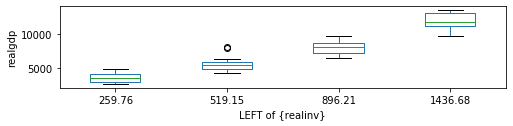

In [451]:
BINPLOT_VA1_parted_eq_by_VA2(
    df= df, 
    va1=  'realgdp', 
    va2 = 'realinv', 
    num_q =4, 
    va2_is_index = False, 
    apply_float_precision = True,
    precision_float = 2,
    fig_size = (8,1.5), 
    show_x_ticks = True
)

# Binplots VA1, w/ DF partitioned by list of pairs of bounds ofg VA2 
* (ONLY FOR int, float, datetime)

In [429]:
def BINPLOT_VA1_parted_by_list_of_pairs_of_VA2(
        df, 
        va1, 
        va2, 
        ls,
        va2_is_index = False, 

        whether_plot = True,
        fig_size = (16,4),
        show_x_ticks = True
    ): 
    """
    Params:
        【va2_is_index】 True:
                Then 【va2】 is just a name of x axis
    Returns: 
        DataFrame of means, stds & counts
    Note:
        1. Check no overlapping region! Region is LEFT <= x < RIGHT
        2. Require no repeating index, for time series index, 
            consider push repeating index by 1ns, repeat 
            until no repetition left.
    """
    
    # setup
    UNIQUE_ID_COL = 'unique_group_identifier_to_be_deleted_by_nathan_3434344' 
    UNIQUE_VA2_INDEX_COL = 'unique_va2_index_to_be_deleted_by_nathan_3434344' 
    STORE_va2 = va2
    if va2_is_index:
        va2 = UNIQUE_VA2_INDEX_COL
        df[va2] = df.index
    
    # groupby / partition
    df[UNIQUE_ID_COL] = -1
    counter = 0
    for pair in ls:
        left, right = pair[0], pair[1]
        if (left != None and right != None): df.loc[(left <= df[va2]) & (df[va2] < right), UNIQUE_ID_COL] = counter
        elif (left == None): df.loc[(df[va2] < right), UNIQUE_ID_COL] = counter
        elif (right == None): df.loc[(left <= df[va2]), UNIQUE_ID_COL] = counter
        else : df[UNIQUE_ID_COL] = counter
        counter += 1
    df_temp = df[df[UNIQUE_ID_COL] != -1]
    unstacked = df_temp.groupby(UNIQUE_ID_COL).apply(lambda x: x[va1]).unstack(level = 0)

    # plot
    if whether_plot:
        ax = unstacked.plot(kind='box',figsize = fig_size)
        if show_x_ticks:
            _ = ax.set_xticklabels(unstacked.columns)
        _ = ax.set_xlabel("RANGE of {" + STORE_va2 + "}")
        _ = ax.set_ylabel(va1)
    
    # restore original df
    df.drop(UNIQUE_ID_COL, axis = 1, inplace = True)
    if va2_is_index: 
        df.drop(UNIQUE_VA2_INDEX_COL, axis = 1, inplace = True)
    
    # return
    ls_means = list(unstacked.mean(axis = 0, skipna = True))
    ls_stds = list(unstacked.std(axis = 0, skipna = True))
    ls_counts =list((-1*(unstacked.isna()-1)).sum())
    columns_ls = list(map(lambda x: "[" + str(x[0]) +", " + str(x[1]) + ")", ls))
    df_ret = pd.DataFrame(data = ([ls_means, ls_stds,ls_counts]),
                          index = ['mean','std','count'],
                          columns = columns_ls)
    df_ret = df_ret.transpose()
    df_ret.rename_axis("RANGE of {" + STORE_va2 + "}", inplace = True)
    return df_ret
    

,mean,std,count
RANGE of {realgdp},,,
"[None, 3500)",326.236125,37.531303,24.0
"[4000, 5000)",545.400063,66.429073,32.0
"[5500, 7000)",801.296742,103.324933,31.0
"[7500, 9000)",1022.572500,86.736666,26.0


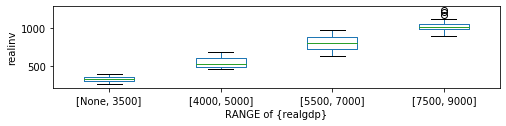

In [444]:
BINPLOT_VA1_parted_by_list_of_pairs_of_VA2(
    df, 
    'realinv', 
    'realgdp', 
    [[None,3500], [4000,5000], [5500,7000], [7500, 9000]],
    fig_size = (8,1.5)
)

,mean,std,count
RANGE of {time},,,
"[1970-01-01 00:00:00, 1975-01-01 00:00:00)",574.027100,68.399385,20.0
"[1976-01-01 00:00:00, 1980-01-01 00:00:00)",722.827812,85.361800,16.0


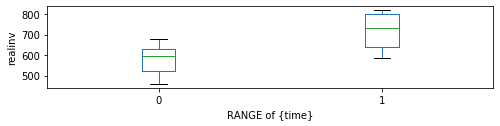

In [445]:
BINPLOT_VA1_parted_by_list_of_pairs_of_VA2(
    df = df, 
    va1 = 'realinv', 
    va2 = 'time', 
    ls = [[pd.to_datetime("1970"), pd.to_datetime("1975")], [pd.to_datetime("1976"), pd.to_datetime("1980")]], 
    va2_is_index = True,
    fig_size = (8,1.5),
    show_x_ticks = False
)

# Binplots VA1, w/ DF partitioned by categorical VA2

In [492]:
def BINPLOT_VA1_parted_by_categorical_VA2(
        df, 
        va1, 
        va2, 
        ls = None,

        whether_plot = True,
        fig_size = (16,4)
    ): 
    """
    Params:
        
    Returns: 
        DataFrame of means, stds & counts
    Note:
        1. Check va2 is categorical
        2. Require no repeating index, for time series index, 
            consider push repeating index by 1ns, repeat 
            until no repetition left.
            
    TODO: extend to multiple categorical va2 values
    TODO: allow multiple category values to take one bin!!!!!!
    """
        
    if ls == None:
        ls = list(df[va2].unique())
    
    # groupby / partition
    df_temp = df[(df[va2].apply(lambda x: (x in ls)))]
    unstacked = df_temp.groupby(va2).apply(lambda x: x[va1]).unstack(level = 0)

    # plot
    if whether_plot:
        ax = unstacked.plot(kind='box',figsize = fig_size)
        _ = ax.set_xlabel("CATEGORY of {" + va2 + "}")
        _ = ax.set_ylabel(va1)
    
#     # return
    ls_means = list(unstacked.mean(axis = 0, skipna = True))
    ls_stds = list(unstacked.std(axis = 0, skipna = True))
    ls_counts =list((-1*(unstacked.isna()-1)).sum())
    df_ret = pd.DataFrame(data = ([ls_means, ls_stds,ls_counts]),
                          index = ['mean','std','count'],
                          columns = unstacked.columns)
    df_ret = df_ret.transpose()
    df_ret.rename_axis("CATEGORY of {" + va2 + "}", inplace = True)
    return df_ret
    

,mean,std,count
CATEGORY of {quarter},,,
1.0,7168.953059,3233.395188,51.0
2.0,7227.666451,3249.759628,51.0
3.0,7278.214667,3263.139718,51.0


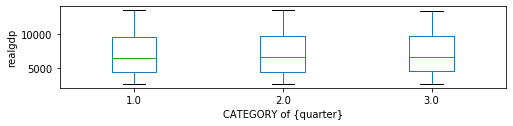

In [493]:
BINPLOT_VA1_parted_by_categorical_VA2(
    df, 
    'realgdp', 
    'quarter',
    [1,2,3],
    fig_size = (8,1.5)
)
